This notebook was written by Richie to build a lightGBM model predicting the number of calls a subscriber will make. Why do some subscribers make more calls that others? We aim to find out!

In [1]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
user_data = pd.read_parquet('G:\My Drive\data science\DataDives\Viamo_user_data_Uganda.parquet')
user_data.head()

,subscriber_id,age,gender,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme,second_fav_theme,fav_topic,second_fav_topic,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric,second_fav_topic_numeric
0,1407945714310841452,over_44,male,15,11,3,13.0,1.0,5.0,,weather,,rice,-1,1.0,-1,4.0
1,1381120932047227576,over_44,male,24,11,2,26.5,1.0,5.0,,financial,,srh,-1,7.0,-1,2.0
2,1413216964176250176,18_24,female,13,11,4,22.0,2.0,2.0,,news,,srh,-1,5.0,-1,2.0
3,1254654060855299012,25_34,male,14,11,4,13.0,1.0,3.0,,weather,,srh,-1,1.0,-1,2.0
4,1397270658647854828,under_18,male,32,11,2,21.0,1.0,1.0,,drama,,srh,-1,8.0,-1,2.0


array([[<AxesSubplot:title={'center':'n_calls'}>,
        <AxesSubplot:title={'center':'n_themes'}>],
       [<AxesSubplot:title={'center':'n_topics'}>,
        <AxesSubplot:title={'center':'median_call_duration'}>],
       [<AxesSubplot:title={'center':'age_numeric'}>, <AxesSubplot:>]],
      dtype=object)

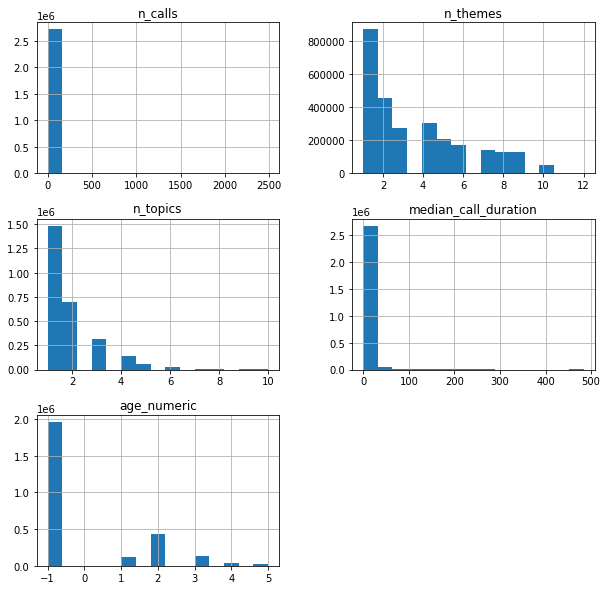

In [7]:
user_data.loc[:,['age','n_calls','n_themes', 'n_topics', 'median_call_duration', 'age_numeric']].hist(bins = 15,figsize=(10,10))

In [8]:
user_data.dropna(subset = ['n_calls'],inplace=True)

NameError: name 'TRUE' is not defined

In [ ]:
import lightgbm as ltb
from sklearn import metrics
Richie_seed = 14

chosen_columns = ['gender_numeric','age_numeric','median_call_duration','n_topics','n_themes', 'fav_theme_numeric', 'second_fav_theme_numeric','fav_topic_numeric', 'second_fav_topic_numeric']

X = user_data.loc[:,chosen_columns].astype(int)
y = user_data.loc[:,'n_calls'].astype(int)

In [ ]:
lgbm_mod = ltb.LGBMRegressor(n_estimators = 1000, random_state=Richie_seed)
lgbm_mod.fit(X,y)

In [ ]:
y_pred = lgbm_mod.predict(X)
y_pred[y_pred<1] = 1
print(metrics.r2_score(y, y_pred))
print(metrics.mean_squared_log_error(y , y_pred))

In [ ]:
import shap
lgbm_explainer = shap.TreeExplainer(lgbm_mod)

X_sample = X.sample(50000)

shap_values = lgbm_explainer.shap_values(X_sample)

In [ ]:
shap.summary_plot(
    shap_values = shap_values,
    features = X_sample,
    plot_type = 'dot',
    plot_size = [20,10]
)

In [ ]:
shap.dependence_plot('age_numeric', shap_values, X_sample)